In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

np.random.seed(123456789)
random.seed(123456789)
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)
plt.style.use("ggplot")

# カラム
# PassengerId: 旅客ID
# Survived: 生存(1: 生存、0: 死亡)
# Pclass: チケットクラス(1 > 2 > 3)
# Name: 名前
# Sex: 性別
# Age: 年齢
# SibSp: 同乗の兄弟/配偶者の数
# Parch: 同乗の親/子供の数
# Ticket: チケット番号
# Fare: 料金
# Cabin: 客室
# Embarked: 乗った港(C: Cherbourg, Q: Queenstown, S: Southampton)
df = pd.DataFrame(pd.read_csv('./train.csv'))
print(df)

test_df = pd.DataFrame(pd.read_csv('./test.csv'))

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name     Sex   Age  SibSp  \
0                              Braund, Mr. Owen Harris    male  22.0      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                               Heikkinen, Miss. Laina  female  26.0      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                             Allen, Mr. William Henry    male  35.0      0   
..                                                 ...     ...   ... 

In [5]:
# データの概要の確認
print("shape: {}".format(df.shape))
df.info()

shape: (891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
print(df["Sex"].value_counts())
print(df["Embarked"].value_counts())
print(df["Cabin"].value_counts())

male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64
C23 C25 C27    4
B96 B98        4
G6             4
C22 C26        3
D              3
              ..
C99            1
D21            1
C30            1
C95            1
B50            1
Name: Cabin, Length: 147, dtype: int64


In [8]:
print(df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


    Embarked  Survived  PassengerId
0          S         0            1
1          C         1            2
2          S         1            3
3          S         1            4
4          S         0            5
..       ...       ...          ...
886        S         0          887
887        S         1          888
888        S         0          889
889        C         1          890
890        Q         0          891

[891 rows x 3 columns]
    Embarked  Survived  PassengerId
0          S         0            1
1          C         1            2
2          S         1            3
3          S         1            4
4          S         0            5
..       ...       ...          ...
886        S         0          887
887        S         1          888
888        S         0          889
889        C         1          890
890        Q         0          891

[889 rows x 3 columns]
                   PassengerId
Embarked Survived             
C        0                

<AxesSubplot:xlabel='Sex'>

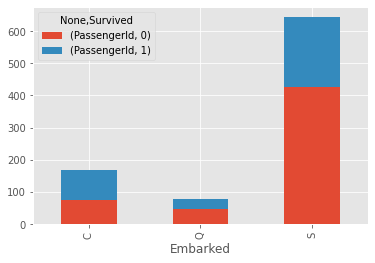

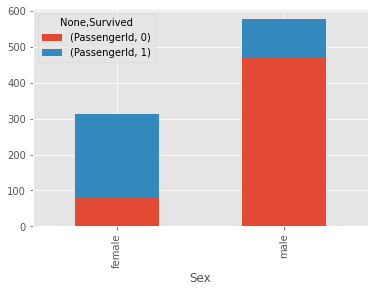

In [9]:
print(df[["Embarked", "Survived", "PassengerId"]])
print(df[["Embarked", "Survived", "PassengerId"]].dropna())
print(df[["Embarked", "Survived", "PassengerId"]].groupby(["Embarked", "Survived"]).count())
embarked_df = df[["Embarked", "Survived", "PassengerId"]].groupby(["Embarked", "Survived"]).count().unstack()
print(embarked_df)
embarked_df.plot.bar(stacked=True)
embarked_df["Survived_Rate"] = embarked_df.iloc[:, 0] / (embarked_df.iloc[:, 0] + embarked_df.iloc[:,1])
print(embarked_df)

sex_df = df[["Sex", "Survived", "PassengerId"]].dropna().groupby(["Sex", "Survived"]).count().unstack()
sex_df.plot.bar(stacked=True)

<AxesSubplot:xlabel='Pclass'>

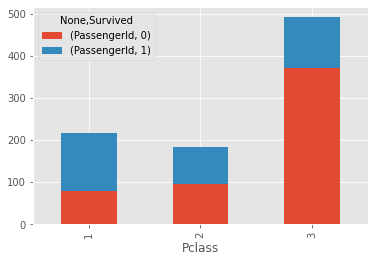

In [10]:
ticket_df = df[["Pclass", "Survived", "PassengerId"]].dropna().groupby(["Pclass", "Survived"]).count().unstack()
ticket_df.plot.bar(stacked=True)

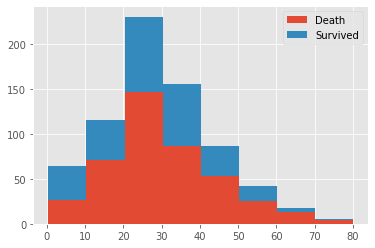

In [11]:
a = df[df["Survived"] == 0][["Age"]].values
b = df[df["Survived"] == 1][["Age"]].values
plt.hist([a.flatten(), b.flatten()], histtype="barstacked", bins=8, label=("Death", "Survived"))
plt.legend()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name   Age  SibSp  Parch  \
0                            Braund, Mr. Owen Harris  22.0      1      0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  38.0      1      0   
2                             Heikkinen, Miss. Laina  26.0      0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  35.0      1      0   
4                           Allen, Mr. William Henry  35.0      0      0   

             Ticket     Fare Cabin  Sex_male  Embarked_C  Embarked_Q  \
0         A/5 21171   7.2500   NaN         1           0           0   
1          PC 17599  71.2833   C85         0           1           0   
2  STON/O2. 3101282   7.9250   NaN         0           0           0   
3            113803  53.1000  C123    

<AxesSubplot:>

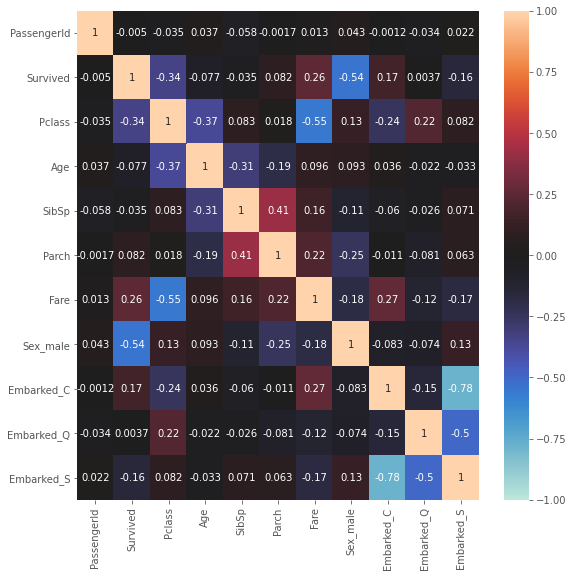

In [12]:
df_corr = pd.get_dummies(df, columns=["Sex"], drop_first=True)
df_corr = pd.get_dummies(df_corr, columns=["Embarked"])
print(df_corr.head())
print(df_corr.corr())
plt.figure(figsize=(9, 9))
sns.heatmap(df_corr.corr(), vmax=1, vmin=-1, center=0, annot=True)

In [13]:
all_df = pd.concat([df, test_df], sort=False).reset_index(drop=True)
print(all_df)
print(all_df.isnull().sum())

      PassengerId  Survived  Pclass  \
0               1       0.0       3   
1               2       1.0       1   
2               3       1.0       3   
3               4       1.0       1   
4               5       0.0       3   
...           ...       ...     ...   
1304         1305       NaN       3   
1305         1306       NaN       1   
1306         1307       NaN       3   
1307         1308       NaN       3   
1308         1309       NaN       3   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male  22.0      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                                Heikkinen, Miss. Laina  female  26.0      0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                              Allen, Mr. William Henry    male  35.0      0   
...                                                

In [14]:
fare_mean = all_df[["Pclass", "Fare"]].groupby(["Pclass"]).mean().reset_index()
print(fare_mean)
fare_mean.columns = ["Pclass", "Fare_mean"]
print(fare_mean)

all_df = pd.merge(all_df, fare_mean, on="Pclass", how="left")
all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
print(all_df)

   Pclass       Fare
0       1  87.508992
1       2  21.179196
2       3  13.302889
   Pclass  Fare_mean
0       1  87.508992
1       2  21.179196
2       3  13.302889
      PassengerId  Survived  Pclass  \
0               1       0.0       3   
1               2       1.0       1   
2               3       1.0       3   
3               4       1.0       1   
4               5       0.0       3   
...           ...       ...     ...   
1304         1305       NaN       3   
1305         1306       NaN       1   
1306         1307       NaN       3   
1307         1308       NaN       3   
1308         1309       NaN       3   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male  22.0      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                                Heikkinen, Miss. Laina  female  26.0      0   
3          Futrelle, Mrs. Jacques Heath (Li

In [15]:
# Mr.: 男性全体
# Master.: 男性の子供
# Mrs.: 未婚女性
# Miss.: 既婚女性
print(all_df["Name"].head(10))
name_df = all_df["Name"].str.split("[,.]", 2, expand=True)
name_df.columns = ["family_name", "honorific", "name"]
print(name_df)
name_df["family_name"] = name_df["family_name"].str.strip()
name_df["honorific"] = name_df["honorific"].str.strip()
name_df["name"] = name_df["name"].str.strip()
print(name_df["honorific"].value_counts())

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object
        family_name honorific                                    name
0            Braund        Mr                             Owen Harris
1           Cumings       Mrs   John Bradley (Florence Briggs Thayer)
2         Heikkinen      Miss                                   Laina
3          Futrelle       Mrs           Jacques Heath (Lily May Peel)
4             Allen        Mr                           William Henry
... 

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Fare_mean',
       'family_name', 'honorific', 'name'],
      dtype='object')


<AxesSubplot:xlabel='honorific', ylabel='Age'>

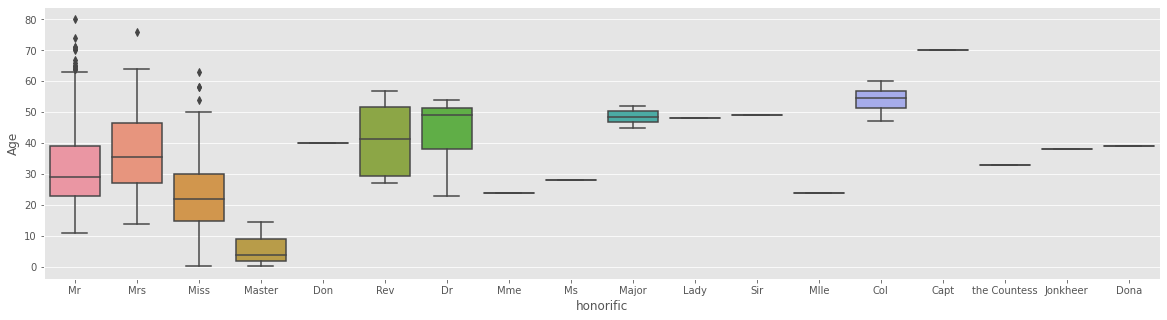

In [16]:
all_df = pd.concat([all_df[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Fare_mean']], name_df], axis=1)
print(all_df.columns)

plt.figure(figsize=(20, 5))
sns.boxplot(x="honorific", y="Age", data=all_df)

                    Age
honorific              
Capt          70.000000
Col           54.000000
Don           40.000000
Dona          39.000000
Dr            43.571429
Jonkheer      38.000000
Lady          48.000000
Major         48.500000
Master         5.482642
Miss          21.774238
Mlle          24.000000
Mme           24.000000
Mr            32.252151
Mrs           36.994118
Ms            28.000000
Rev           41.250000
Sir           49.000000
the Countess  33.000000
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      

<AxesSubplot:xlabel='honorific'>

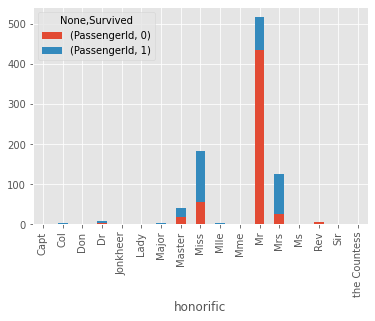

In [17]:
print(all_df[["Age", "honorific"]].groupby("honorific").mean())
tmp_df = pd.concat([df, name_df[0:len(df)].reset_index(drop=True)], axis=1)
print(tmp_df.head(5))
tmp_df2 = pd.concat([test_df, name_df[len(df):].reset_index(drop=True)], axis=1)
print(tmp_df2.head(5))

honorific_df = tmp_df[["honorific", "Survived", "PassengerId"]].dropna().groupby(["honorific", "Survived"]).count().unstack()
honorific_df.plot.bar(stacked=True)

In [18]:
honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").mean().reset_index()
honorific_age_mean.columns = ["honorific", "honorific_Age"]
print(honorific_age_mean)

all_df = pd.merge(all_df[['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Fare_mean',
       'family_name', 'honorific', 'name']], honorific_age_mean, on="honorific", how="left")
all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_Age"]
print(all_df.loc[(all_df["Age"].isnull()), "Age"])

       honorific  honorific_Age
0           Capt      70.000000
1            Col      54.000000
2            Don      40.000000
3           Dona      39.000000
4             Dr      43.571429
5       Jonkheer      38.000000
6           Lady      48.000000
7          Major      48.500000
8         Master       5.482642
9           Miss      21.774238
10          Mlle      24.000000
11           Mme      24.000000
12            Mr      32.252151
13           Mrs      36.994118
14            Ms      28.000000
15           Rev      41.250000
16           Sir      49.000000
17  the Countess      33.000000
Series([], Name: Age, dtype: float64)


0     790
1     235
2     159
3      43
5      25
4      22
6      16
10     11
7       8
Name: family_num, dtype: int64
           PassengerId       
Survived           0.0    1.0
family_num                   
0                374.0  163.0
1                 72.0   89.0
2                 43.0   59.0
3                  8.0   21.0
4                 12.0    3.0
5                 19.0    3.0
6                  8.0    4.0
7                  6.0    NaN
10                 7.0    NaN


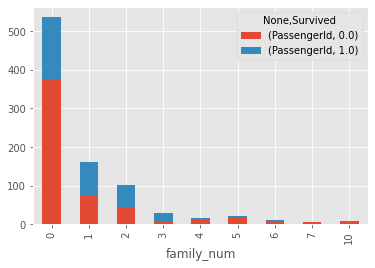

In [19]:
all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
print(all_df["family_num"].value_counts())
family_num_df = all_df[["family_num", "Survived", "PassengerId"]].groupby(["family_num", "Survived"]).count().unstack()
print(family_num_df)
family_num_df.plot.bar(stacked=True)

all_df.loc[all_df["family_num"] == 0, "alone"] = 1
all_df["alone"].fillna(0, inplace=True)

In [20]:
drop_all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)
print(drop_all_df)

      Survived  Pclass     Sex        Age  SibSp  Parch      Fare Embarked  \
0          0.0       3    male  22.000000      1      0    7.2500        S   
1          1.0       1  female  38.000000      1      0   71.2833        C   
2          1.0       3  female  26.000000      0      0    7.9250        S   
3          1.0       1  female  35.000000      1      0   53.1000        S   
4          0.0       3    male  35.000000      0      0    8.0500        S   
...        ...     ...     ...        ...    ...    ...       ...      ...   
1304       NaN       3    male  32.252151      0      0    8.0500        S   
1305       NaN       1  female  39.000000      0      0  108.9000        C   
1306       NaN       3    male  38.500000      0      0    7.2500        S   
1307       NaN       3    male  32.252151      0      0    8.0500        S   
1308       NaN       3    male   5.482642      1      1   22.3583        C   

      Fare_mean honorific  honorific_Age  family_num  alone  
0

In [21]:
categories = drop_all_df.columns[drop_all_df.dtypes == "object"]
print(categories)

drop_all_df.loc[~((drop_all_df["honorific"] == "Mr") | (drop_all_df["honorific"] == "Miss") | (drop_all_df["honorific"] == "Master") | (drop_all_df["honorific"] == "Mrs")), "honorific"] = "other"
print(drop_all_df.honorific.value_counts())

drop_all_df["Embarked"].fillna("missing", inplace=True)
print(drop_all_df["Embarked"].isnull().any())

Index(['Sex', 'Embarked', 'honorific'], dtype='object')
Mr        757
Miss      260
Mrs       197
Master     61
other      34
Name: honorific, dtype: int64
False


In [22]:
# le = LabelEncoder()
# le = le.fit(drop_all_df["Sex"])
# drop_all_df["Sex"] = le.transform(drop_all_df["Sex"])
# print(drop_all_df["Sex"].value_counts())

for cat in categories:
    print(cat)
    le = LabelEncoder()
    if drop_all_df[cat].dtypes == "object":
        le = le.fit(drop_all_df[cat])
        drop_all_df[cat] = le.transform(drop_all_df[cat])
        print(drop_all_df[cat].value_counts())
print(drop_all_df.head())
print(drop_all_df["honorific"].value_counts())

Sex
1    843
0    466
Name: Sex, dtype: int64
Embarked
2    914
0    270
1    123
3      2
Name: Embarked, dtype: int64
honorific
2    757
1    260
3    197
0     61
4     34
Name: honorific, dtype: int64
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Fare_mean  \
0       0.0       3    1  22.0      1      0   7.2500         2  13.302889   
1       1.0       1    0  38.0      1      0  71.2833         0  87.508992   
2       1.0       3    0  26.0      0      0   7.9250         2  13.302889   
3       1.0       1    0  35.0      1      0  53.1000         2  87.508992   
4       0.0       3    1  35.0      0      0   8.0500         2  13.302889   

   honorific  honorific_Age  family_num  alone  
0          2      32.252151           1    0.0  
1          3      36.994118           1    0.0  
2          1      21.774238           0    1.0  
3          3      36.994118           1    0.0  
4          2      32.252151           0    1.0  
2    757
1    260
3    197
0    

In [23]:
print(drop_all_df.head())
print(drop_all_df.info())



   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Fare_mean  \
0       0.0       3    1  22.0      1      0   7.2500         2  13.302889   
1       1.0       1    0  38.0      1      0  71.2833         0  87.508992   
2       1.0       3    0  26.0      0      0   7.9250         2  13.302889   
3       1.0       1    0  35.0      1      0  53.1000         2  87.508992   
4       0.0       3    1  35.0      0      0   8.0500         2  13.302889   

   honorific  honorific_Age  family_num  alone  
0          2      32.252151           1    0.0  
1          3      36.994118           1    0.0  
2          1      21.774238           0    1.0  
3          3      36.994118           1    0.0  
4          2      32.252151           0    1.0  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Survived       891 non-null    float6

In [24]:
train_X = drop_all_df[~drop_all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
train_Y = df["Survived"]

test_X = drop_all_df[drop_all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

print(train_X.head())
print(train_Y.head())
print(test_X.head())

   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Fare_mean  honorific  \
0       3    1  22.0      1      0   7.2500         2  13.302889          2   
1       1    0  38.0      1      0  71.2833         0  87.508992          3   
2       3    0  26.0      0      0   7.9250         2  13.302889          1   
3       1    0  35.0      1      0  53.1000         2  87.508992          3   
4       3    1  35.0      0      0   8.0500         2  13.302889          2   

   honorific_Age  family_num  alone  
0      32.252151           1    0.0  
1      36.994118           1    0.0  
2      21.774238           0    1.0  
3      36.994118           1    0.0  
4      32.252151           0    1.0  
0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64
   Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  Fare_mean  honorific  \
0       3    1  34.5      0      0   7.8292         1  13.302889          2   
1       3    0  47.0      1      0   7.0000         2  13.302889          3

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)
categories = ["Embarked", "Pclass", "Sex", "honorific", "alone"]

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)

lgb_params = {
    "objective": "binary",
    "random_seed": 1234
}

model_lgb = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval, num_boost_round=100, early_stopping_rounds=20, verbose_eval=10)
print(model_lgb.feature_importance())

[LightGBM] [Info] Number of positive: 281, number of negative: 431
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 239
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394663 -> initscore=-0.427753
[LightGBM] [Info] Start training from score -0.427753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

<AxesSubplot:>

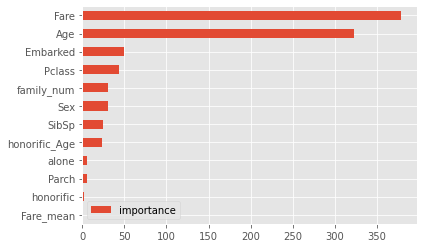

In [31]:
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=True)
importance.plot.barh()

In [34]:
from sklearn.metrics import accuracy_score
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
print(accuracy_score(y_valid, np.round(y_pred)))

0.8491620111731844
